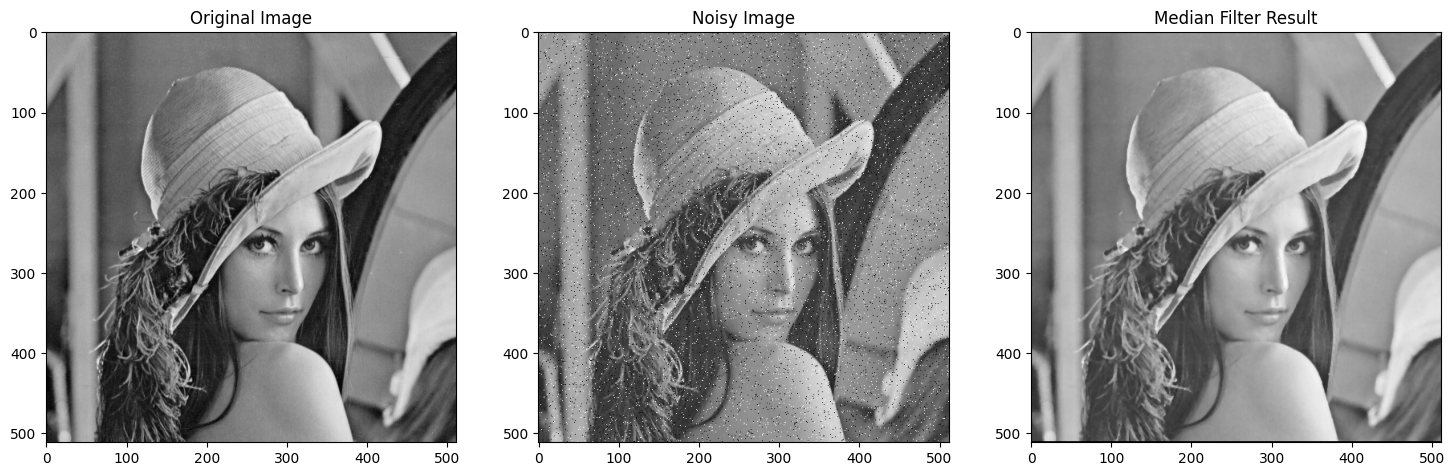

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def apply_median_filter(image, kernel_size):
    image_height, image_width = image.shape
    half_kernel = kernel_size // 2
    result = np.zeros_like(image, dtype=np.uint8)

    for i in range(half_kernel, image_height - half_kernel):
        for j in range(half_kernel, image_width - half_kernel):
            neighborhood = image[i - half_kernel : i + half_kernel + 1, j - half_kernel : j + half_kernel + 1]
            median_value = np.median(neighborhood)
            result[i, j] = int(median_value)

    return result

def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)
    salt_mask = np.random.random(image.shape) < salt_prob
    pepper_mask = np.random.random(image.shape) < pepper_prob
    noisy_image[salt_mask] = 255

    noisy_image[pepper_mask] = 0

    return noisy_image

image = plt.imread('lena.png')


if len(image.shape) == 3:
    image = np.mean(image, axis=-1)

image = (image * 255).astype(np.uint8)

noisy_image = add_salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02)

median_result = apply_median_filter(noisy_image, 3)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')

plt.subplot(1, 3, 3)
plt.imshow(median_result, cmap='gray')
plt.title('Median Filter Result')

plt.show()


In [15]:

import numpy as np
import cv2 as cv
import math
import matplotlib.pyplot as plt


img_filename1 ='noisyImage_Gaussian.jpg'
image1= cv.imread(img_filename1, 0)

img_filename = 'noise_pepper.jpg'
image = cv.imread(img_filename, 0)

img_filename2 = 'lena_grayscale_hq.jpg'
groundTruth = cv.imread(img_filename2, 0)


#normalise image [0-1]
normalised_image= cv.normalize(image1, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)


def adaptiveMeanFilter(normalised_image,Sxy,noise_variance):   
    (h, w) = normalised_image.shape[:2]
    local_average=np.zeros((h,w))
    mean_squared_image=np.zeros((h,w))
    f=np.zeros((h,w))
    #padding
    top=left=right=bottom=(Sxy-1)//2
    padded_image = cv.copyMakeBorder( normalised_image,top, bottom, left, right, cv.BORDER_REPLICATE, None, value = 0 )
    #finding mean image
    for i in range(w):
        for j in range(h):
            temp = padded_image[i:i + Sxy, j:j + Sxy]
            local_average[i,j]=np.mean(temp)   
    #square of mean image
    square_mean_image=np.square(local_average)
    #square of image
    squared_image=np.square(padded_image)
    #mean of squared image
    for i in range(w):
        for j in range(h):
            temp2 = squared_image[i:i + Sxy, j:j + Sxy]
            mean_squared_image[i,j]=np.mean(temp2)
    #local variance
    local_variance= mean_squared_image - square_mean_image
    #formule implamentation
    f=normalised_image - ((noise_variance / local_variance) * (normalised_image - local_average ) )
    #get back[0-255]
    f = cv.normalize(f, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

    return f.astype(np.uint8)

#my adaptive median filter 
output_1_1=adaptiveMeanFilter(normalised_image,5,0.004)
#OpenCV 5x5 box filter
output_1_2=cv.blur(image1, (5,5), borderType = cv.BORDER_CONSTANT)
#OpenCV 5x5 Gaussian filter (with auto var  σ = 0).
output_1_3=cv.GaussianBlur(image1, (5, 5), 0, borderType = cv.BORDER_CONSTANT)


#QUESTION 2
def adaptiveMedianFilter(img, windowSize): 
    #padding
    top=bottom=left=right=windowSize
    padImg = cv.copyMakeBorder( image, top, bottom, left, right, cv.BORDER_REPLICATE, value = 0 )

    row = padImg.shape[0]
    col = padImg.shape[1]

    sMax = 7
    a=sMax//2
    filter_output = np.zeros(padImg.shape)
    for y in range(a, row - 1):
        for x in range(a, col - 1):
            filter_output[y, x] = stageA(padImg, y, x, windowSize, sMax)

    return filter_output[a:-a,a:-a].astype(np.uint8)
def stageA(img, y, x, windowSize, sMax):
    img_part = img[y - (windowSize//2):y + (windowSize//2) + 1, x - (windowSize//2):x + (windowSize//2) + 1]
    
    zmin = np.min(img_part)
    zmed = np.median(img_part)
    zmax = np.max(img_part)
    
    A1 = zmed - zmin
    A2 = zmed - zmax

    if A1 > 0 and A2 < 0:                       #go to level B
        return stageB(img_part, zmin, zmed, zmax)
    else:
        windowSize = windowSize + 2             #increase window size (must be odd so add 2)
        if windowSize <= sMax:                  #window size is lower than Smax, repeat level A 
            return stageA(img,y,x,windowSize,sMax)
        else:                                   # return zmed
            return zmed
def stageB(img, zmin, zmed, zmax):
    h,w = img.shape
    zxy = img[h // 2, w //2]

    B1 = zxy - zmin
    B2 = zxy - zmax

    if B1 > 0 and B2 < 0:   #return Zxy
        return zxy
    else:
        return zmed         #return zmed

#center weighted median filter
def weightedMedianFilter(image, kernelSize):
    h, w = image.shape
    # Padding
    top = bottom = int((kernelSize - 1) / 2)  # rows
    left = right = int((kernelSize - 1) / 2)  # cols
    padImg = cv.copyMakeBorder(image, top, bottom, left, right, cv.BORDER_REPLICATE)

    filter_out = np.zeros_like(image)  # Initialize output image with the same dimensions as the input

    # Convolution
    for i in range(top, h + top):
        for j in range(left, w + left):
            temp = padImg[i - top:i + top + 1, j - left:j + left + 1]
            centerValue = temp[top, left]

            # Create a weighted list of pixel values
            weighted_values = []
            for m in range(kernelSize):
                for n in range(kernelSize):
                    if 0 <= i - top + m < h and 0 <= j - left + n < w:
                        weight = 1 / (1 + np.sqrt((m - kernelSize // 2)**2 + (n - kernelSize // 2)**2))
                        weighted_values.append((temp[m, n], weight))

            # Sort the list based on weights
            sorted_values = sorted(weighted_values, key=lambda x: x[1])

            # Find the median value using np.median
            median = np.median(np.array(sorted_values)[:, 0])

            filter_out[i - top, j - left] = median

    filter_out = filter_out.astype(np.uint8)
    return filter_out

output_2_1=adaptiveMedianFilter(image,3)
output_2_2=cv.medianBlur(image,3)
output_2_3=cv.medianBlur(image,5)
output_2_4=cv.medianBlur(image,7)
output_2_5=weightedMedianFilter(image,3)
output_2_6=weightedMedianFilter(image,5)
output_2_7=weightedMedianFilter(image,7)

#PSNR
# psnr_1_1=cv.PSNR(groundTruth,output_1_1) 
# psnr_1_2=cv.PSNR(groundTruth,output_1_2) 
# psnr_1_3=cv.PSNR(groundTruth,output_1_3) 

# psnr_2_1=cv.PSNR(groundTruth,output_2_1) 
# psnr_2_2=cv.PSNR(groundTruth,output_2_2)  
# psnr_2_3=cv.PSNR(groundTruth,output_2_3)  
# psnr_2_4=cv.PSNR(groundTruth,output_2_4)  
# psnr_2_5=cv.PSNR(groundTruth,output_2_5)  
# psnr_2_6=cv.PSNR(groundTruth,output_2_6)  
# psnr_2_7=cv.PSNR(groundTruth,output_2_7) 




C:\Windows\Temp\ipykernel_17596\1474419401.py:100: RuntimeWarning: overflow encountered in ubyte_scalars
  B2 = zxy - zmax


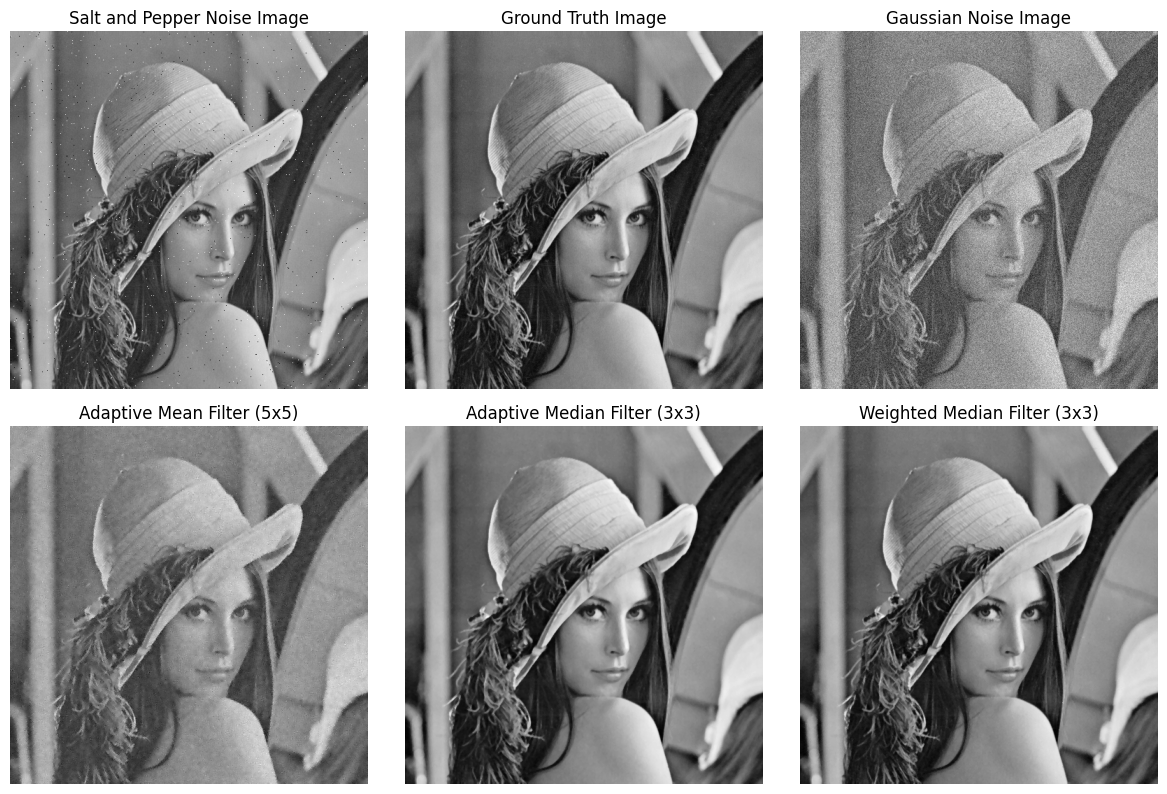

In [5]:
plt.figure(figsize=(12, 12))

# Original and Ground Truth Images
plt.subplot(3, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Salt and Pepper Noise Image')
plt.axis('off')

plt.subplot(3, 3, 2)
plt.imshow(groundTruth, cmap='gray')
plt.title('Ground Truth Image')
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(image1, cmap='gray')
plt.title('Gaussian Noise Image')
plt.axis('off')

# Adaptive Mean Filter Results
plt.subplot(3, 3, 4)
plt.imshow(output_1_1, cmap='gray')
plt.title('Adaptive Mean Filter (5x5)')
plt.axis('off')


# Adaptive Median Filter and Weighted Median Filter Results
plt.subplot(3, 3, 5)
plt.imshow(output_2_1, cmap='gray')
plt.title('Adaptive Median Filter (3x3)')
plt.axis('off')

plt.subplot(3, 3, 6)
plt.imshow(output_2_5, cmap='gray')
plt.title('Weighted Median Filter (3x3)')
plt.axis('off')


# Show the plots
plt.tight_layout()
plt.show()


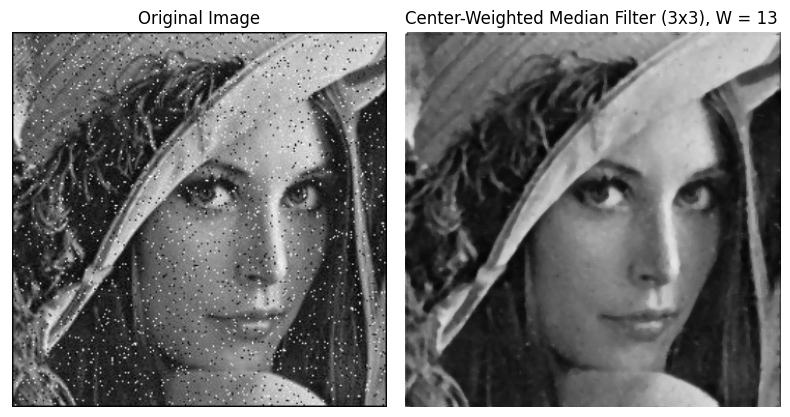

In [17]:
def weightedMedianFilter(image, kernelSize,weight):
    h, w = image.shape
    # Padding
    top = bottom = int((kernelSize - 1) / 2)  # rows
    left = right = int((kernelSize - 1) / 2)  # cols
    padImg = cv.copyMakeBorder(image, top, bottom, left, right, cv.BORDER_REPLICATE)

    filter_out = np.zeros_like(image)  # Initialize output image with the same dimensions as the input

    # Convolution
    for i in range(top, h + top):
        for j in range(left, w + left):
            temp = padImg[i - top:i + top + 1, j - left:j + left + 1]
            centerValue = temp[top, left]

            # Create a weighted list of pixel values
            weighted_values = []
            for m in range(kernelSize):
                for n in range(kernelSize):
                    if 0 <= i - top + m < h and 0 <= j - left + n < w:
                        #weight = 1 / (1 + np.sqrt((m - kernelSize // 2)**2 + (n - kernelSize // 2)**2))
                        weighted_values.append((temp[m, n], weight))

            # Sort the list based on weights
            sorted_values = sorted(weighted_values, key=lambda x: x[1])

            # Find the median value using np.median
            median = np.median(np.array(sorted_values)[:, 0])

            filter_out[i - top, j - left] = median

    filter_out = filter_out.astype(np.uint8)
    return filter_out

# Example usage
img_filename = 'noise_pepper.jpg'
image = cv.imread(img_filename, 0)

# Center-Weighted Median Filter
output_center_weighted = weightedMedianFilter(image, 5,13)

# Display Results using Matplotlib
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_center_weighted, cmap='gray')
plt.title('Center-Weighted Median Filter (3x3), W = 13')
plt.axis('off')

plt.tight_layout()
plt.show()
